# Memory Retrieval Inductive Biases [`dev`]

TODO:
- make memory retrieval symmetric
- gating
- 

$$
\begin{align*}
x^{(t)} &= (x_1^{(t)}, \ldots, x_{l_m}^{(t)})\\
x &= (x_1, \ldots, x_{l_x})
\end{align*}
$$

$$
\begin{align*}
E^{(t)} &\gets \mathrm{CausalSelfAttn}(x_1^{(t)}, \ldots, x_{l_m}^{(t)})\\
E &\gets \mathrm{CausalSelfAttn}(x_1, \ldots, x_{l_x})
\end{align*}
$$

$$
\mathrm{HierAttn}(Q \gets E_i, K \gets E^{(t)}, V \gets E^{(t)} / y^{(t)})
$$

$$K(x_i, x^{(t)}) = \phi_q(\mathrm{CausalSelfAttn}(x_1, \ldots, x_i))^\top \phi_k(\mathrm{CausalSelfAttn}(x_1^{(t)}, \ldots, x_j^{(t)}))$$


$l_x \times l_m \times n_m \times n_h$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from tqdm.keras import TqdmCallback

import itertools
import sys;sys.path.append('..')
import utils

import tensorflow as tf
from tensorflow.keras import layers

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Generate Data

In [3]:
n_states = 16
m = 2

state_tuples = list(itertools.product(range(n_states), repeat=m))
len(state_tuples)

256

In [4]:
transition_dict = dict()

for state_tuple in state_tuples:
    next_state = np.random.randint(n_states)
    p = np.zeros(n_states)
    p[next_state] = 1

    transition_dict[state_tuple] = p

In [5]:
def sample_markov_chain(transition_dict, prefix, num_steps):
    states_seq = prefix
    m = len(list(transition_dict.keys())[0])

    for i in range(num_steps-m):
        probabilities = transition_dict[tuple(states_seq[-m:])]
        next_state = np.random.choice(range(n_states), p=probabilities)
        states_seq.append(next_state)
    return states_seq

In [6]:
input_seq_len = 32 # length of input sequences
mem_seq_len = 5*m # length of each memory sequence
mem_size = 16 # number of memory sequences

n_train = 400
n_test = 400

def sample_seqs_dataset(n, input_seq_len):
    seqs = np.array([sample_markov_chain(
        transition_dict, prefix=list(state_tuples[np.random.choice(len(state_tuples))]), num_steps=input_seq_len+1) for _ in range(n)])

    seqs_x = seqs[:, :-1]
    seqs_y = seqs[:, 1:]

    return seqs_x, seqs_y


def sample_mem_dataset(mem_seq_len, mem_size, input_seq=None, num_subseqs=1):
    mem_seqs = np.array([sample_markov_chain(
        transition_dict, prefix=list(state_tuples[np.random.choice(len(state_tuples))]), num_steps=mem_seq_len+1)
         for _ in range(mem_size)])
    # mem_seqs = np.repeat(np.expand_dims(mem_seqs, axis=0), axis=0, repeats=n)
    mem_seqs = mem_seqs

    mem_seqs_x = mem_seqs[:, :-1]
    mem_seqs_y = mem_seqs[:, 1:]

    if input_seq is not None:
        x_len = len(input_seq)
        for _ in range(num_subseqs):
            start_idx = np.random.randint(0, x_len - mem_seq_len - 1)
            x_subseq = input_seq[start_idx:start_idx+mem_seq_len]
            y_subseq = input_seq[start_idx+1:start_idx+1+mem_seq_len]

            mem_seqs_x = np.concatenate([mem_seqs_x, np.expand_dims(x_subseq, axis=0)])
            mem_seqs_y = np.concatenate([mem_seqs_y, np.expand_dims(y_subseq, axis=0)])

    return mem_seqs_x, mem_seqs_y

seqs_x_train, seqs_y_train = sample_seqs_dataset(n_train, input_seq_len)
seqs_x_test, seqs_y_test = sample_seqs_dataset(n_test, input_seq_len)

mem_seqs_x, mem_seqs_y = sample_mem_dataset(mem_seq_len, mem_size)


# sample memory buffers randomly
mem_seqs_x_train, mem_seqs_y_train = zip(*[sample_mem_dataset(mem_seq_len, mem_size, input_seq, num_subseqs=1) for input_seq in seqs_x_train])
mem_seqs_x_test, mem_seqs_y_test = zip(*[sample_mem_dataset(mem_seq_len, mem_size, input_seq, num_subseqs=1) for input_seq in seqs_x_test])

mem_seqs_x_train, mem_seqs_y_train = np.array(mem_seqs_x_train), np.array(mem_seqs_y_train)
mem_seqs_x_test, mem_seqs_y_test = np.array(mem_seqs_x_test), np.array(mem_seqs_y_test)

In [7]:
print(f'seqs_x_train.shape: {seqs_x_train.shape}; seqs_y_train.shape: {seqs_y_train.shape}') # shape [batch_size, seq_len]
print(f'mem_seqs_x_train.shape: {mem_seqs_x_train.shape}; mem_seqs_y.shape: {mem_seqs_y_train.shape}') # shape [batch_size, num_mem_seqs, mem_seq_len]

seqs_x_train.shape: (400, 32); seqs_y_train.shape: (400, 32)
mem_seqs_x_train.shape: (400, 17, 10); mem_seqs_y.shape: (400, 17, 10)


In [8]:
fit_kwargs = dict(epochs=30)

from tqdm.keras import TqdmCallback
from tqdm import tqdm
def create_callbacks():
    return [TqdmCallback(tqdm_class=tqdm)]

# Hierarchical Attn Model

In [51]:
train_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_train, mem_seqs_x_train, mem_seqs_y_train), seqs_y_train)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test, mem_seqs_y_test), seqs_y_test)).batch(64)

In [52]:
from transformer_modules import AddPositionalEmbedding, create_positional_encoding, MemoryAddPositionalEmbedding
from transformer_modules import GlobalSelfAttention, CausalSelfAttention
from hierarchical_attention import MultiHeadHierarchicalAttention


class HierarchicalAttnMemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, symmetric_attention=False, **kwargs):
        super().__init__(**kwargs)
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different attention layers for input and memories
        # self.self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        # self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')
        self.self_attention_layer = CausalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        if symmetric_attention:
            self.memory_self_attention_layer = self.self_attention_layer
        else:
            self.memory_self_attention_layer = GlobalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')

        # same attention layers for input and memories
        # self.self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='self_attn')
        # self.memory_self_attention_layer = self.self_attention_layer

        self.hierarchical_mem_attention = MultiHeadHierarchicalAttention(
            key_dim, value_dim=embedding_dim, symmetric_kernel=True, n_heads=n_heads,
            attn_scale_factor_per_seq=1, attn_scale_factor_over_seqs=1,
            dense_kwargs=dict(use_bias=False), name='mem_attn')

        self.output_dense = layers.Dense(vocab_size, name='output')

    def self_attention(self, seq):
        # return self.self_attention_layer(seq, seq, use_causal_mask=True)
        return self.self_attention_layer(seq)

    def memory_self_attention(self, mem_seqs):
        # lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=True)
        lambda_fn = lambda x: self.memory_self_attention_layer(x)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)

        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)

        retrieved_mems = self.hierarchical_mem_attention([embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs])

        logits = self.output_dense(retrieved_mems)

        return logits

In [53]:
vocab_size = len(state_tuples)
embedding_dim = 64

memory_model2 = HierarchicalAttnMemoryModel(
    vocab_size, embedding_dim=embedding_dim, symmetric_attention=True,
    key_dim=embedding_dim//3, n_heads=3, name='memory_model')

memory_model2([seqs_x_train, mem_seqs_x_train, mem_seqs_y_train]); # build model

create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
memory_model2.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model2.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  16384     
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 causal_self_attention_2 (Ca  multiple                 16509     
 usalSelfAttention)                                              
                                                                 
 mem_attn (MultiHeadHierarch  multiple                 16320     
 icalAttention)                                       

100%|██████████| 60/60 [01:46<00:00,  1.78s/epoch, loss=0.251, accuracy=0.929, val_loss=0.433, val_accuracy=0.893]


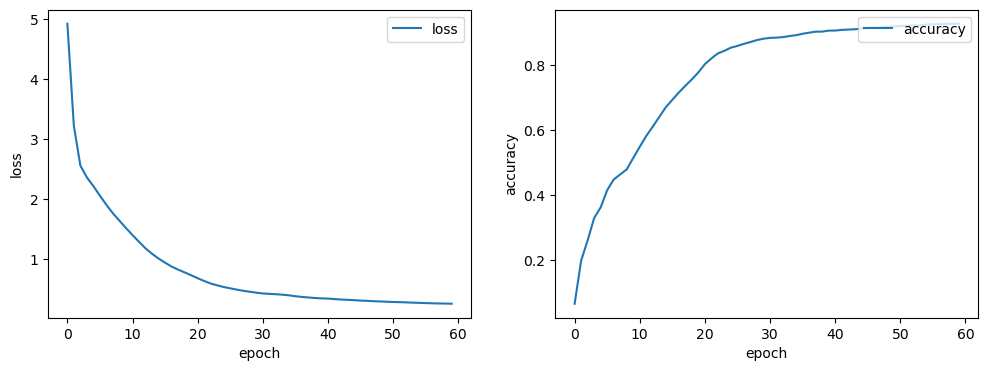

In [54]:
history2 = memory_model2.fit(train_ds, validation_data=test_ds, verbose=0, callbacks=create_callbacks(), epochs=60)
utils.plot_history(history2, plot_attrs=('loss', 'accuracy'), val=True, figsize=(12,4));

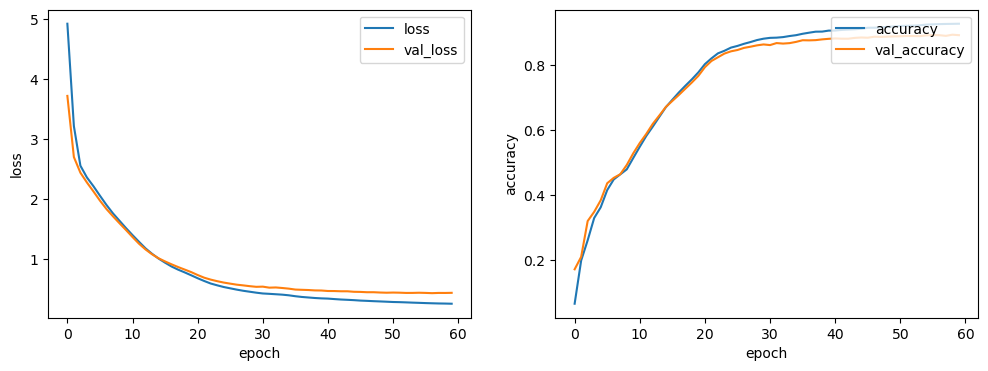

In [55]:
utils.plot_history(history2, plot_attrs=('loss', 'accuracy'), val=True, figsize=(12,4));

7/7 [==============================] - 1s 73ms/step


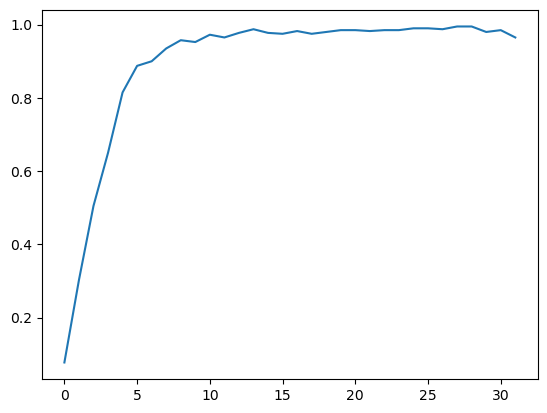

In [56]:
# plot accuracy as a function of position in sequence
preds = memory_model2.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_test, axis=0)
plt.plot(acc_by_pos)

In [65]:
# utilities for analyzing attention patterns in hierarchical attention model
import matplotlib.pyplot as plt
from matplotlib import gridspec


def plot_per_seq_attention(attn_, mem_seqs_x, train_seqs_x):
    num_mem_seqs = attn_.shape[0]
    fig = plt.figure(figsize=(num_mem_seqs*2,3))
    gs = gridspec.GridSpec(1, num_mem_seqs+1, width_ratios=[0.5]*num_mem_seqs+[0.1])
    axs = [fig.add_subplot(gs[i]) for i in range(num_mem_seqs)]
    cax = fig.add_subplot(gs[-1])
    im = None
    for t, ax in enumerate(axs):
        im = ax.imshow(attn_[t], cmap='gray', vmin=0, vmax=1)
        ax.set_xticks(range(len(mem_seqs_x[t])))
        ax.set_yticks(range(len(train_seqs_x)))
        ax.set_xticklabels(mem_seqs_x[t]);
        ax.set_yticklabels(train_seqs_x);
    fig.colorbar(im, cax=cax)
    axs[0].set_ylabel('input sequence')
    fig.supxlabel('memory sequences', y=0.)
    fig.suptitle('attention within each memory sequence')
    return fig

def plot_seq_attention(attn_, mem_seqs_x, train_seqs_x, **figkwargs):

    fig, ax = plt.subplots(figsize=(len(train_seqs_x), len(mem_seqs_x)))
    cmap = 'gray' if attn_.shape[-1] == 1 else None
    im = ax.imshow(attn_, cmap='gray', vmin=0, vmax=1)
    ax.set_yticks(range(len(mem_seqs_x)))
    ax.set_xticks(range(len(train_seqs_x)))
    ax.set_yticklabels([tuple(x) for x in mem_seqs_x]);
    ax.set_xticklabels(train_seqs_x);

    ax.set_xlabel('input sequence')
    ax.set_ylabel('memory sequences')
    ax.set_title('attention over sequences')

    fig.colorbar(im, ax=ax);
    return fig


def plot_attention_hierarchical(sample_input_index, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model):
    """
    choose sample input and plot the attention associated to the argmax probability vocab at each input position 
    (memory_seq versus each input element), call plot_seq_attention as subfunction
    """
    b = sample_input_index
    sample_input = seqs_x_train[b:b+1]
    print("sample_input: ",sample_input)
    sample_mem_seq_x = mem_seqs_x_train[b:b+1]
    sample_mem_seq_y = mem_seqs_y_train[b:b+1]

    pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
    pred = np.argmax(pred, axis=-1)
    print(f'prediction: {pred[0]}')
    print(f'y: {seqs_y_train[b]}')
    print(pred[0] == seqs_y_train[b])
    attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

    fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])
    attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]
    plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);

memory_model1
sample_input:  [[ 7  7  3  6 13  9  1 14  8  2  9  7  5 11 10  9 12  8 10 13 12  4  9  9
  13 14 14 11  5 12  9 13]]
prediction: [15 15 12  7  8  1 14  8  2  9  7  5 11 10  9 12  8 10 13 12  4  9  9 13
 14 14 11  5 12  9 13 14]
y: [ 7  3  6 13  9  1 14  8  2  9  7  5 11 10  9 12  8 10 13 12  4  9  9 13
 14 14 11  5 12  9 13 14]
[False False False False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


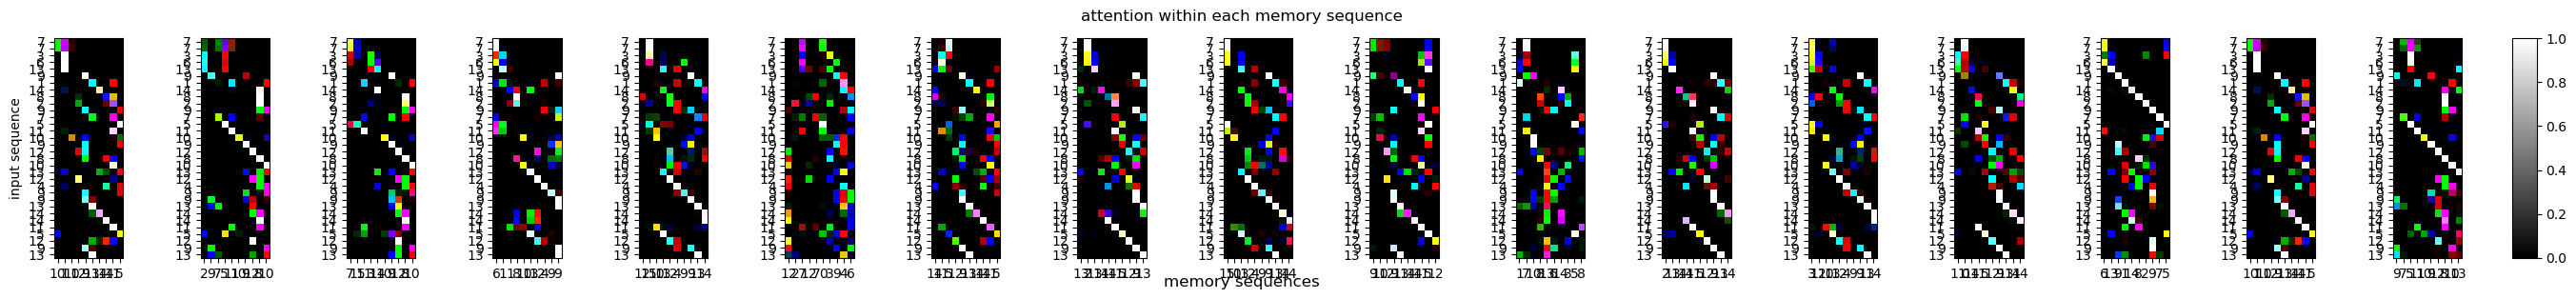

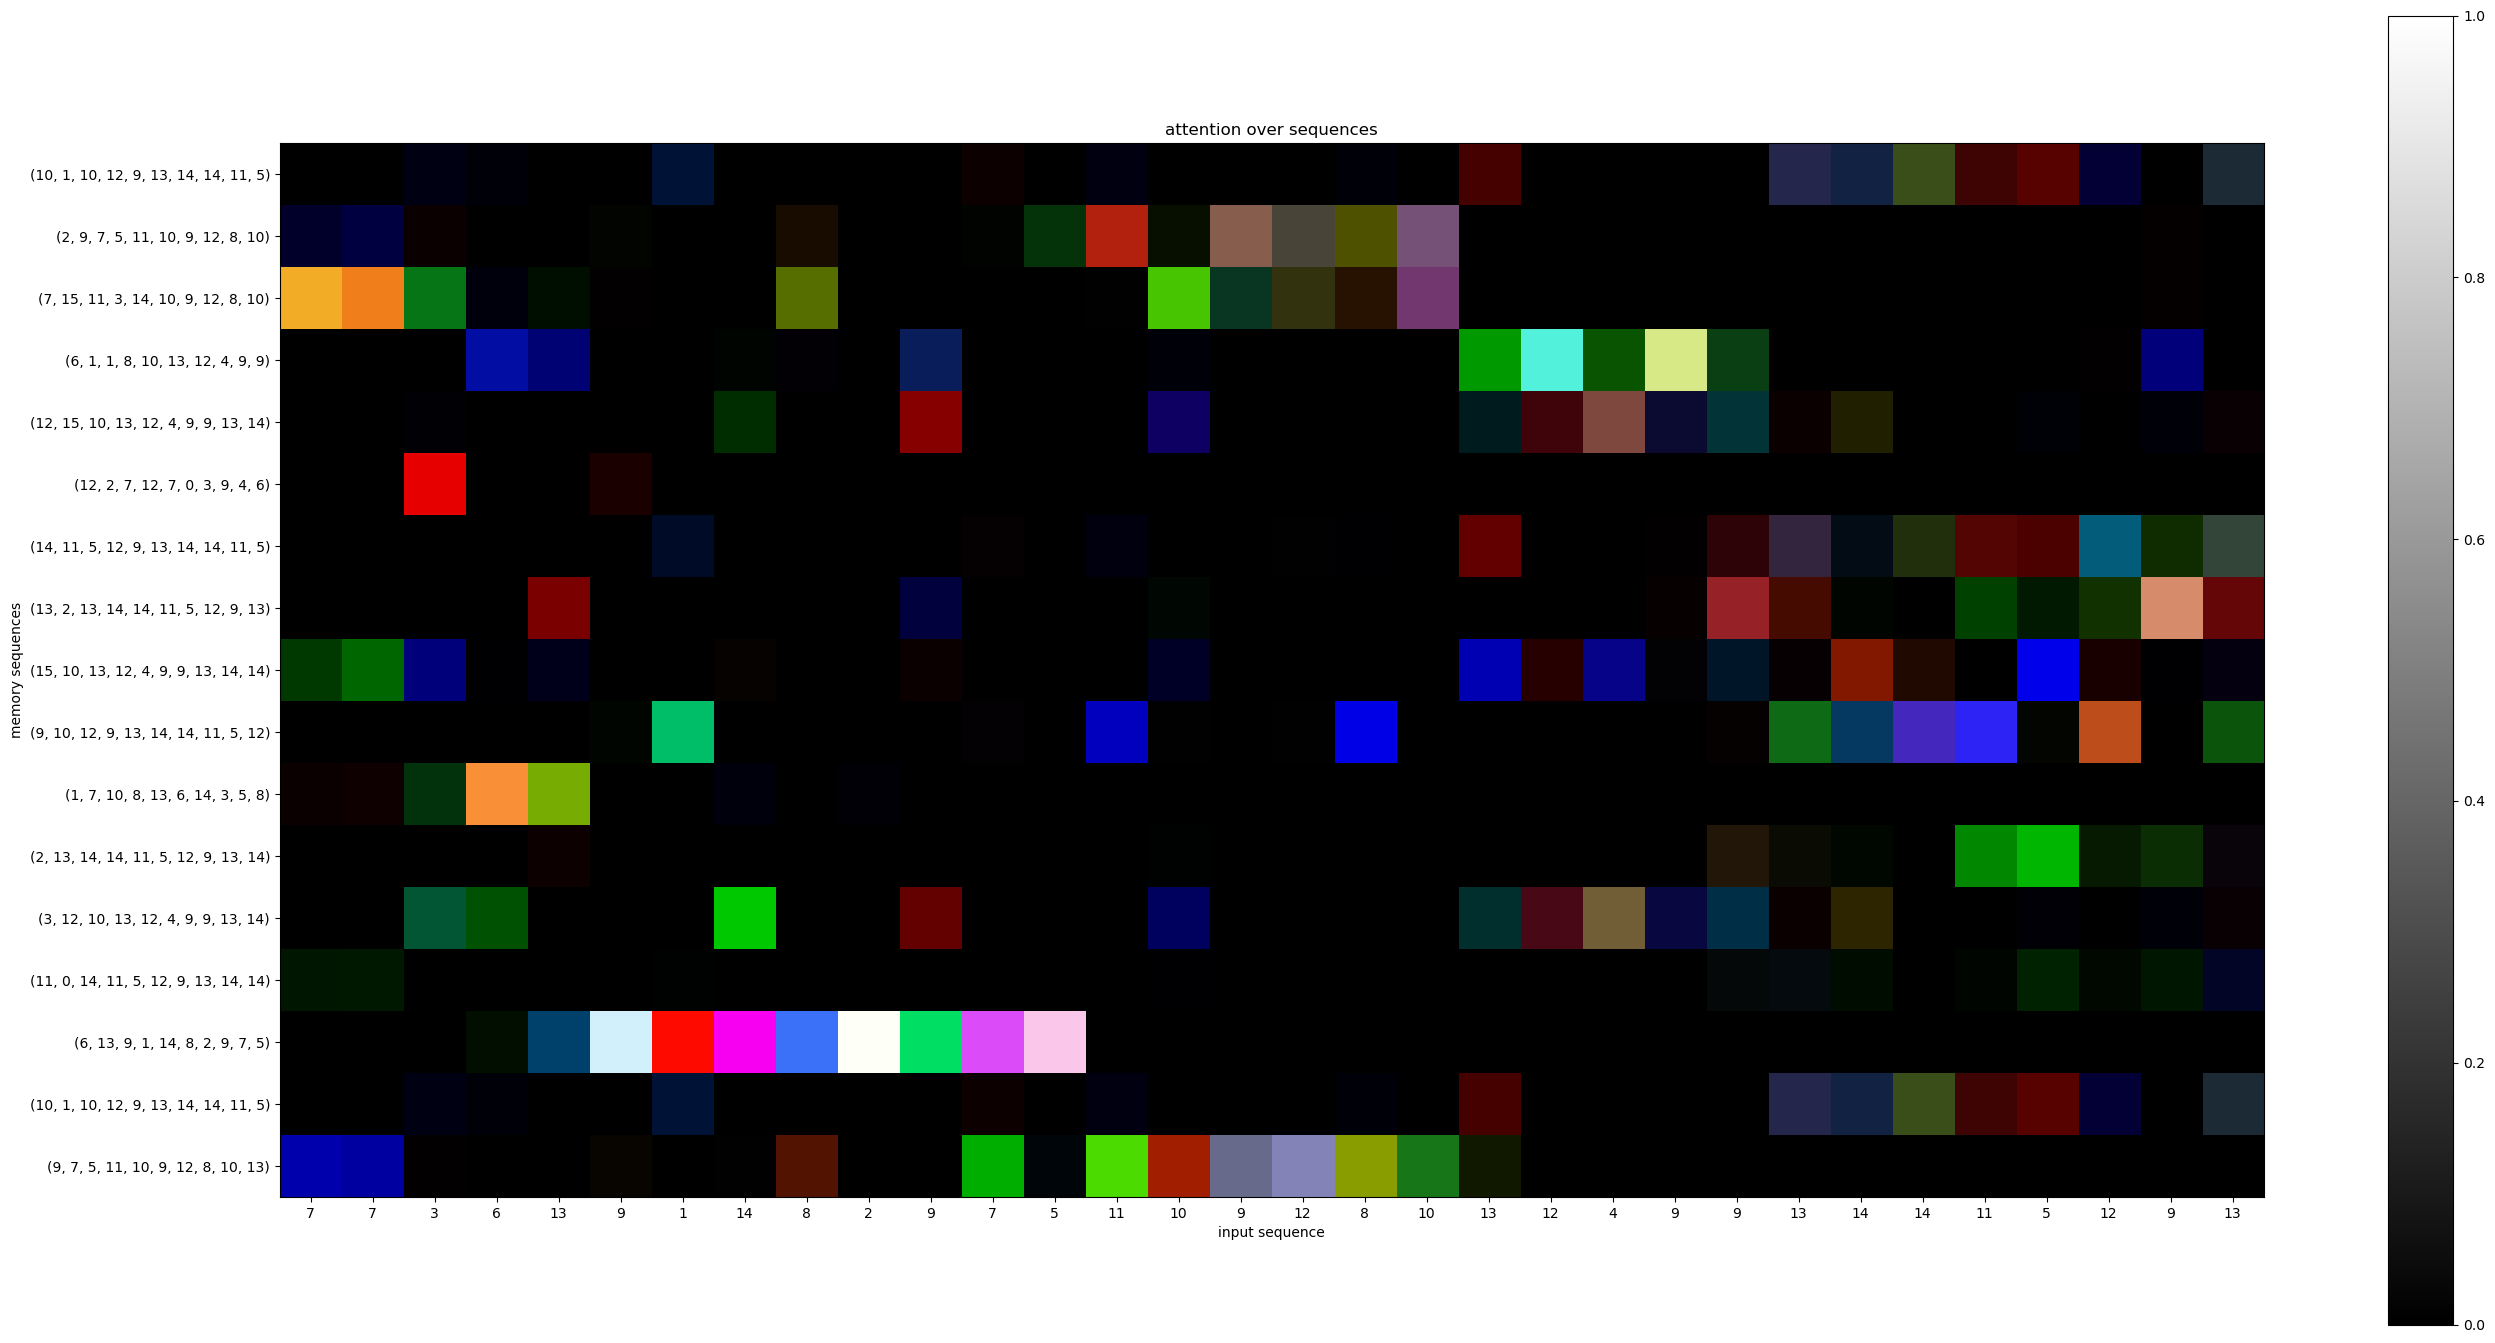

In [66]:
# mem_seqs_x_test, mem_seqs_y_test = zip(*[sample_mem_dataset(mem_seq_len, mem_size) for _ in range(n_test)])
# mem_seqs_x_test, mem_seqs_y_test = np.array(mem_seqs_x_test), np.array(mem_seqs_y_test)

mem_seqs_x_train, mem_seqs_y_train = zip(*[sample_mem_dataset(mem_seq_len, mem_size, input_seq, num_subseqs=1) for input_seq in seqs_x_train])
mem_seqs_x_test, mem_seqs_y_test = zip(*[sample_mem_dataset(mem_seq_len, mem_size, input_seq, num_subseqs=1) for input_seq in seqs_x_test])

mem_seqs_x_train, mem_seqs_y_train = np.array(mem_seqs_x_train), np.array(mem_seqs_y_train)
mem_seqs_x_test, mem_seqs_y_test = np.array(mem_seqs_x_test), np.array(mem_seqs_y_test)

idx = np.random.choice(len(seqs_x_test))
print('memory_model1')
# plot_attention(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, memory_model1)
# print('memory_model2')
plot_attention_hierarchical(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, memory_model2)
# print('memory_model3')
# plot_attention_cross_y(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, memory_model3)


# Kernel Model

In [15]:
import tensorflow as tf
from tensorflow.keras import layers
from transformer_modules import AddPositionalEmbedding, MemoryAddPositionalEmbedding
from custom_attention import GlobalSelfAttention, CausalSelfAttention, CrossAttention

class KernelMemoryTransformer(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, ff_sizes, symmetric_attention=False, **kwargs):
        super().__init__(**kwargs)

        self.symmetric_attention = symmetric_attention
        self.alpha_it = None
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different self-attention layers for input and memories for encoding sequences
        self.input_self_attention = CausalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        if symmetric_attention:
            self.memory_self_attention_layer = self.input_self_attention
        else:
            self.memory_self_attention_layer = GlobalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')

        # create cross attention layer
        self.cross_attention_layer = CrossAttention(num_heads=n_heads, key_dim=key_dim, symmetric_attention=symmetric_attention, name='cross_attn')

        self.feedforward = tf.keras.Sequential([layers.Dense(z, activation='relu') for z in ff_sizes], name='feedforward')
        self.output_dense = layers.Dense(vocab_size, activation='softmax', name='output')

    def memory_self_attention(self, mem_seqs):
        '''apply self-attention to each memory sequence'''
        lambda_fn = lambda x: self.memory_self_attention_layer(x)
        return tf.map_fn(lambda_fn, mem_seqs)

    def get_cross_probs(self, embedded_input_seqs, embedded_mem_x_seqs):
        '''compute cross attention probabilities prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory'''

        def get_memory_cross_probs(Et):
            cross_attention_output = self.cross_attention_layer(
                x=embedded_input_seqs,
                context=Et)
            return cross_attention_output # shape: (batch_size, seq_len, mem_len)

        # compute cross-attention for each memory
        cross_probs = tf.map_fn(get_memory_cross_probs, tf.transpose(embedded_mem_x_seqs, perm=[1, 0, 2, 3]))
        cross_probs = tf.transpose(cross_probs, perm=[1, 0, 2, 3]) # shape: (batch_size, n_mem, mem_length, embedding_dim)

        # compute cross-probs from cross-attention via feedforward network
        cross_probs = self.feedforward(cross_probs)
        cross_probs = self.output_dense(cross_probs) # shape: (batch_size, n_mems, mem_length, vocab_size)

        return cross_probs

    def get_observed_cross_probs(self, cross_probs, seq_input):
        '''given the cross_probs tensor, extract the components coresponding to the observed sequence'''

        cross_probs_observed = tf.transpose(cross_probs, perm=(1,0,2,3))
        cross_probs_observed = tf.map_fn(lambda x: tf.gather(x, indices=seq_input, axis=-1, batch_dims=2), cross_probs_observed)
        cross_probs_observed = tf.transpose(cross_probs_observed, perm=(1,0,2))
        return cross_probs_observed

    def compute_mem_attention_scores(self, cross_probs_observed):
        '''compute memory-level attention scores, alpha_it (i is position in input sequence, t is memory index)'''

        log_cross_probs_observed = tf.math.log(cross_probs_observed)
        w_it = tf.math.cumsum(log_cross_probs_observed, axis=-1, exclusive=True)
        alpha_it = tf.nn.softmax(w_it, axis=1) # shape [batch_size, num_mems, in_seq_length]
        return alpha_it

    def call(self, inputs):
        seq_input, memory_input = inputs

        # embed input sequences and memory sequences
        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_input)

        # add positional embeddings
        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)

        # encode via self-attention
        embedded_input_seqs = self.input_self_attention(embedded_input_seqs) # shape: (batch_size, input_length, embedding_dim)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs) # shape: (batch_size, num_memories, memory_length, embedding_dim)

        # compute prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory
        cross_probs = self.get_cross_probs(embedded_input_seqs, embedded_mem_x_seqs)

        # compute prob(x_{i+1} | x_{1:i}, x^{(t)}) for each memory
        cross_probs_observed = self.get_observed_cross_probs(cross_probs, seq_input)

        # compute alpha_it = softmax(w_it) where w_it = sum_{j=1}^{i-1} log prob(x_{j+1} | x_{1:j}, x^{(t)})
        alpha_it = self.compute_mem_attention_scores(cross_probs_observed)
        self.alpha_it = alpha_it

        # compute prob(x_{i+1} | x_{1:i}, {x^{(t)}}_t) = \sum_t alpha_it * prob(x_{i+1} = . | x_{1:i}, x^{(t)})
        output = tf.reduce_sum(tf.multiply(tf.expand_dims(alpha_it, axis=-1), cross_probs), axis=1)

        return output


In [16]:
train_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_train, mem_seqs_x_train), seqs_y_train)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test), seqs_y_test)).batch(64)

vocab_size = len(state_tuples)
embedding_dim = 64
memory_model1 = KernelMemoryTransformer(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, ff_sizes = [vocab_size//2,], name='kernel_memory_model')

memory_model1([seqs_x_train[:64], mem_seqs_x_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
memory_model1.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model1.summary()

Model: "kernel_memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  16384     
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 causal_self_attention_3 (Ca  multiple                 12608     
 usalSelfAttention)                                              
                                                                 
 global_self_attention_3 (Gl  multiple                 12608     
 obalSelfAttention)                            

100%|██████████| 60/60 [07:24<00:00,  7.41s/epoch, loss=0.141, accuracy=0.963, val_loss=0.208, val_accuracy=0.945]


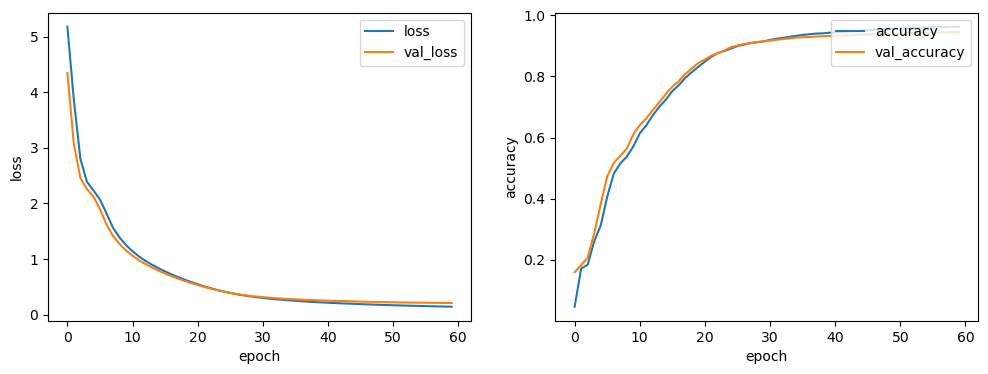

In [17]:
history1 = memory_model1.fit(train_ds, validation_data=test_ds, verbose=0, callbacks=create_callbacks(), epochs=60)
utils.plot_history(history1, plot_attrs=('loss', 'accuracy'), val=True, figsize=(12,4));

7/7 [==============================] - 7s 286ms/step


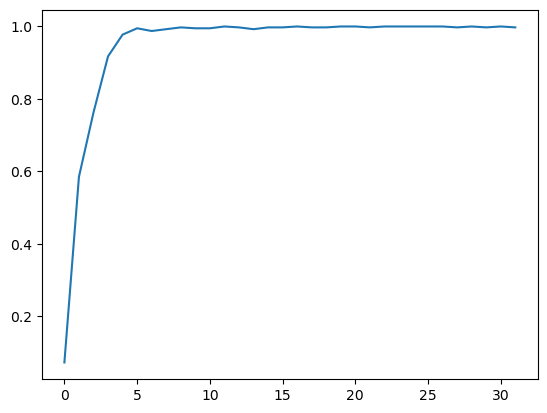

In [18]:
# plot accuracy as a function of position in sequence
preds = memory_model1.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_test, axis=0)
plt.plot(acc_by_pos)

In [19]:
from utils_kernel_transformer import plot_attention

memory_model1
sample_input:  [[10 10 13  2 15 14  2 14  7  0 10 12 15  9 11 15 11  0 14  4 13  9 12 12
   9  7  6 15  4 12 12  9]]
prediction: [13 13  2 15 14  2 14  7  0 10 12 15  9 11 15 11  0 14  4 13  9 12 12  9
  7  6 15  4 12 12  9  7]
y: [10 13  2 15 14  2 14  7  0 10 12 15  9 11 15 11  0 14  4 13  9 12 12  9
  7  6 15  4 12 12  9  7]
[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


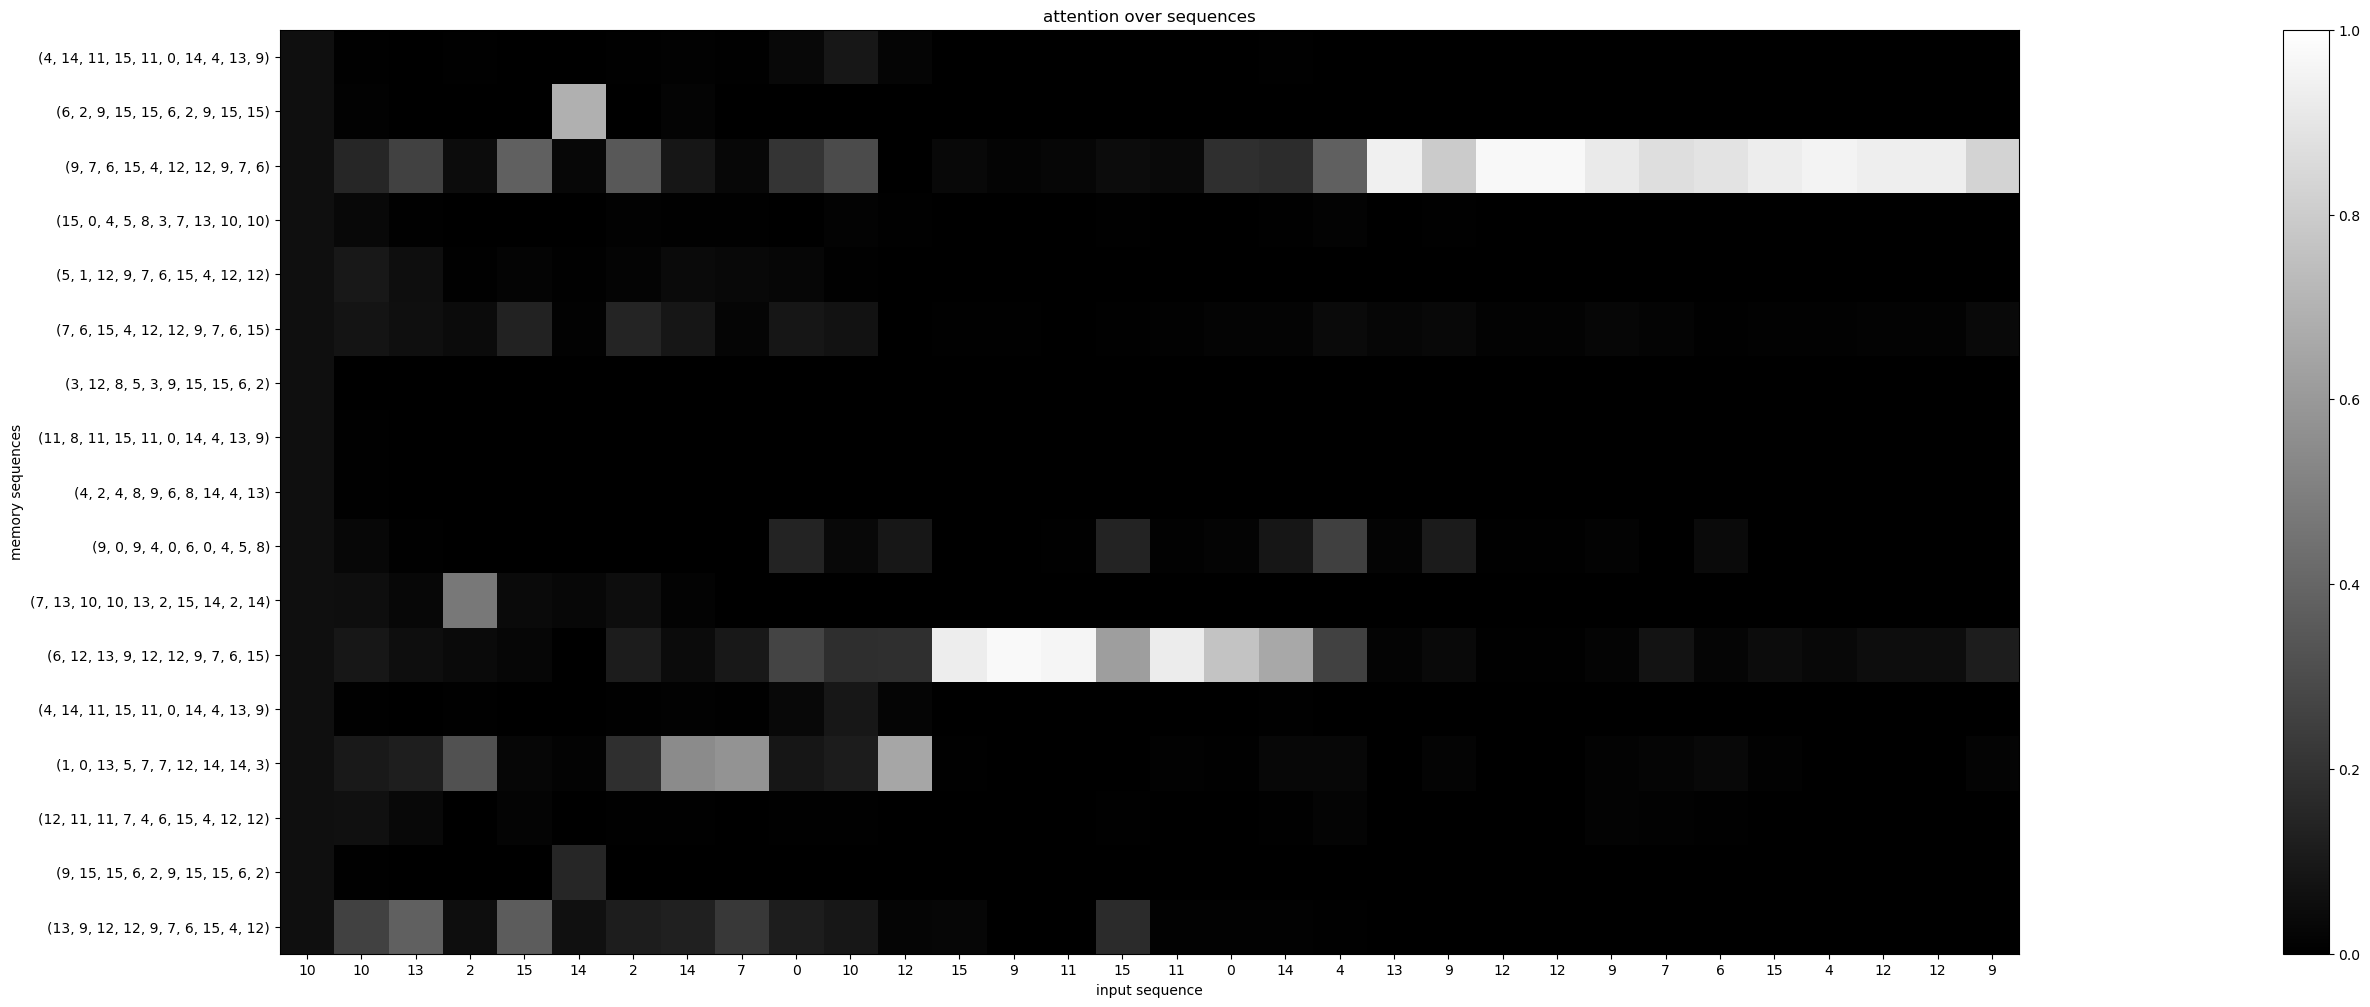

In [27]:
# mem_seqs_x_test, mem_seqs_y_test = zip(*[sample_mem_dataset(mem_seq_len, mem_size) for _ in range(n_test)])
# mem_seqs_x_test, mem_seqs_y_test = np.array(mem_seqs_x_test), np.array(mem_seqs_y_test)

mem_seqs_x_train, mem_seqs_y_train = zip(*[sample_mem_dataset(mem_seq_len, mem_size, input_seq, num_subseqs=1) for input_seq in seqs_x_train])
mem_seqs_x_test, mem_seqs_y_test = zip(*[sample_mem_dataset(mem_seq_len, mem_size, input_seq, num_subseqs=1) for input_seq in seqs_x_test])

mem_seqs_x_train, mem_seqs_y_train = np.array(mem_seqs_x_train), np.array(mem_seqs_y_train)
mem_seqs_x_test, mem_seqs_y_test = np.array(mem_seqs_x_test), np.array(mem_seqs_y_test)

idx = np.random.choice(len(seqs_x_test))
print('memory_model1')

plot_attention(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, memory_model1)


memory_model1
sample_input:  [[ 2 11  9 15 15  6  2  9 15 15  6  2  9 15 15  6  2  9 15 15  6  2  9 15
  15  6  2  9 15 15  6  2]]
prediction: [ 5  9 15 15  6  2  9 15 15  6  2  9 15 15  6  2  9 15 15  6  2  9 15 15
  6  2  9 15 15  6  2  9]
y: [11  9 15 15  6  2  9 15 15  6  2  9 15 15  6  2  9 15 15  6  2  9 15 15
  6  2  9 15 15  6  2  9]
[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


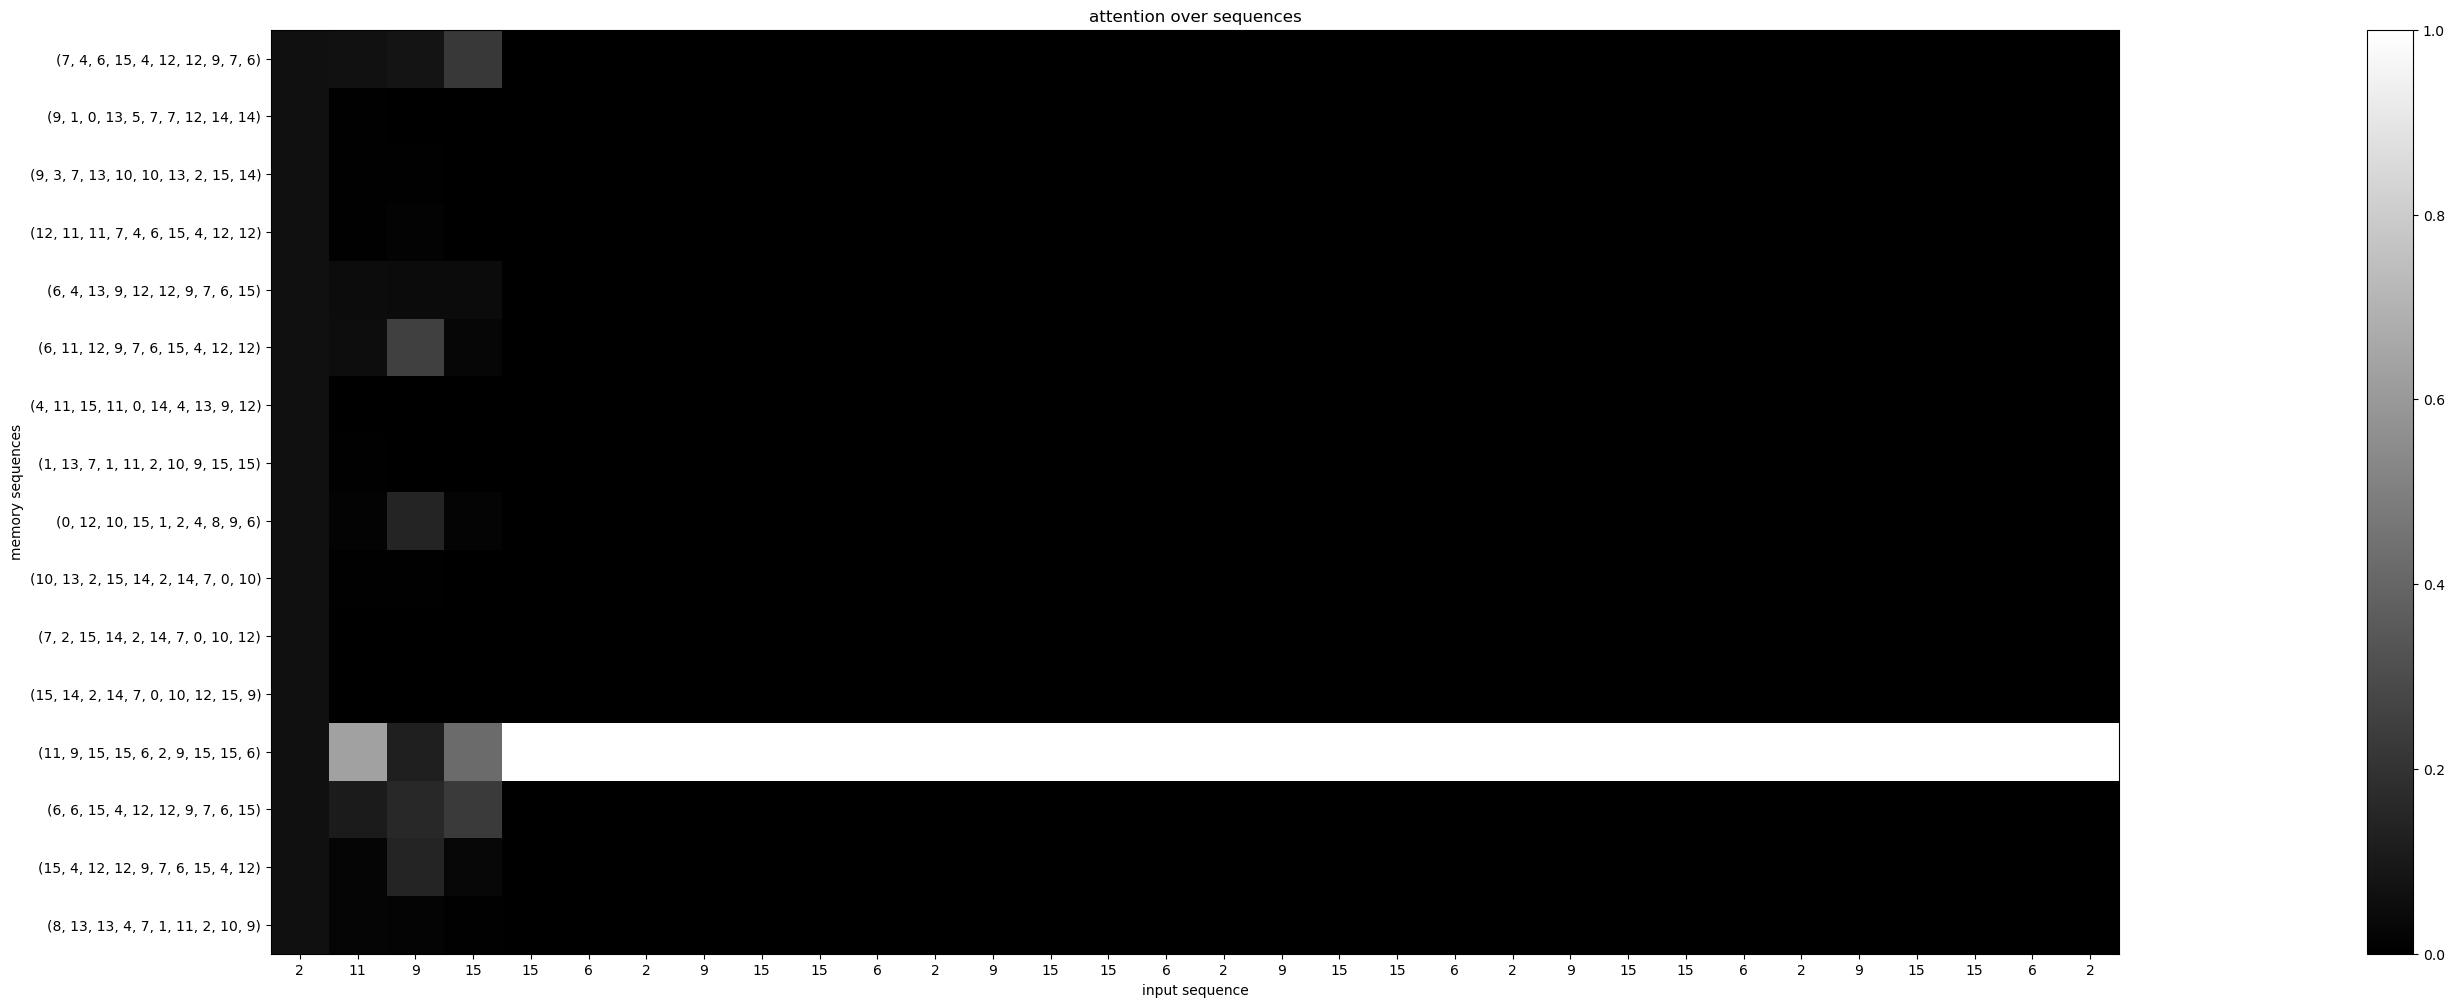

In [30]:
# mem_seqs_x_test, mem_seqs_y_test = zip(*[sample_mem_dataset(mem_seq_len, mem_size) for _ in range(n_test)])
# mem_seqs_x_test, mem_seqs_y_test = np.array(mem_seqs_x_test), np.array(mem_seqs_y_test)

mem_seqs_x_train, mem_seqs_y_train = zip(*[sample_mem_dataset(mem_seq_len, mem_size, input_seq, num_subseqs=0) for input_seq in seqs_x_train])
mem_seqs_x_test, mem_seqs_y_test = zip(*[sample_mem_dataset(mem_seq_len, mem_size, input_seq, num_subseqs=0) for input_seq in seqs_x_test])

mem_seqs_x_train, mem_seqs_y_train = np.array(mem_seqs_x_train), np.array(mem_seqs_y_train)
mem_seqs_x_test, mem_seqs_y_test = np.array(mem_seqs_x_test), np.array(mem_seqs_y_test)

idx = np.random.choice(len(seqs_x_test))
print('memory_model1')

plot_attention(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, memory_model1)


In [34]:
accs = []
nums_subseqs = [0, 1, 2, 4, 8, 16]
for num_subseqs in tqdm(nums_subseqs):
    mem_seqs_x_test, mem_seqs_y_test = zip(*[sample_mem_dataset(mem_seq_len, mem_size, input_seq, num_subseqs=num_subseqs) for input_seq in seqs_x_test])
    mem_seqs_x_test, mem_seqs_y_test = np.array(mem_seqs_x_test), np.array(mem_seqs_y_test)

    test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test), seqs_y_test)).batch(64)
    _, acc = memory_model1.evaluate(test_ds, verbose=0)
    accs.append(acc)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:48<00:00,  8.07s/it]


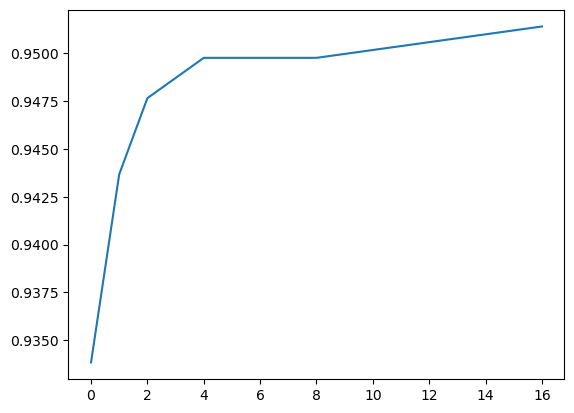

In [35]:
plt.plot(nums_subseqs, accs)